<img src = "https://i.imgur.com/LKLpFOv.png">

In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pprint
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
import cv2
import wandb

from PIL import Image
from colorama import Fore, Back, Style
# colored output
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

I will be integrating W&B for ```visualizations``` and ```logging artifacts```!

[SIIM Project on W&B Dashboard](https://wandb.ai/ruchi798/siim?workspace=user-ruchi798)

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("api_key")

os.environ["WANDB_SILENT"] = "true"

CONFIG = {'competition': 'siim-fisabio-rsna', '_wandb_kernel': 'ruch'}

! wandb login $api_key

In [3]:
train_image_level = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
train_study_level = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")

| id    | unique study identifier                                      |
|-------|--------------------------------------------------------------|
| boxes | bounding boxes in easily-readable dictionary format          |
| label | the correct prediction label for the provided bounding boxes |

In [4]:
train_image_level.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                     none 1 0 0 1 1     ff0879eb20ed  
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e

| id                       | unique study identifier                                  |
|--------------------------|----------------------------------------------------------|
| Negative for Pneumonia   | 1 : if the study is negative for pneumonia, 0: otherwise |
| Typical Appearance       | 1: if the study has this appearance, 0: otherwise        |
| Indeterminate Appearance | 1: if the study has this appearance, 0: otherwise        |
| Atypical Appearance      | 1: if the study has this appearance, 0: otherwise        |

In [5]:
train_study_level.head()

id  Negative for Pneumonia  Typical Appearance  \
0  00086460a852_study                       0                   1   
1  000c9c05fd14_study                       0                   0   
2  00292f8c37bd_study                       1                   0   
3  005057b3f880_study                       1                   0   
4  0051d9b12e72_study                       0                   0   

   Indeterminate Appearance  Atypical Appearance  
0                         0                    0  
1                         0                    1  
2                         0                    0  
3                         0                    0  
4                         0                    1

In [6]:
train_directory = "../input/siim-covid19-detection/train/"
test_directory = "../input/siim-covid19-detection/test/"

train_study_level['StudyInstanceUID'] = train_study_level['id'].apply(lambda x: x.replace('_study', ''))
del train_study_level['id']
train_df = train_image_level.merge(train_study_level, on='StudyInstanceUID')

In [7]:
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

   Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       1                   0                         0   
2                       0                   1                         0   
3                       0                   0                         0   
4                       0                   1                         0   

   Atypical Appearance  
0                    0  
1                    0  
2                    0  
3                    1  
4                    0

In [8]:
training_paths = []

for sid in tqdm(train_df['StudyInstanceUID']):
    training_paths.append(glob.glob(os.path.join(train_directory, sid +"/*/*"))[0])

train_df['path'] = training_paths

100%|██████████| 6334/6334 [00:29<00:00, 212.68it/s]


In [9]:
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

   Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       1                   0                         0   
2                       0                   1                         0   
3                       0                   0                         0   
4                       0                   1                         0   

   Atypical Appearance                                               path  
0                    0  ../input/siim-covid19-detection/train/5776db0c...  
1                    0  ../input/siim-covid19-detection/train/ff0879eb...  
2                    0  ../input/siim-covid19-detection/train/9d514ce4...  
3                    1  ../input/siim-covid19-detection/train/28dddc85...  
4                    0  ../input/siim-covid19-detection/train/dfd9fdd8...

# Distribution of class labels

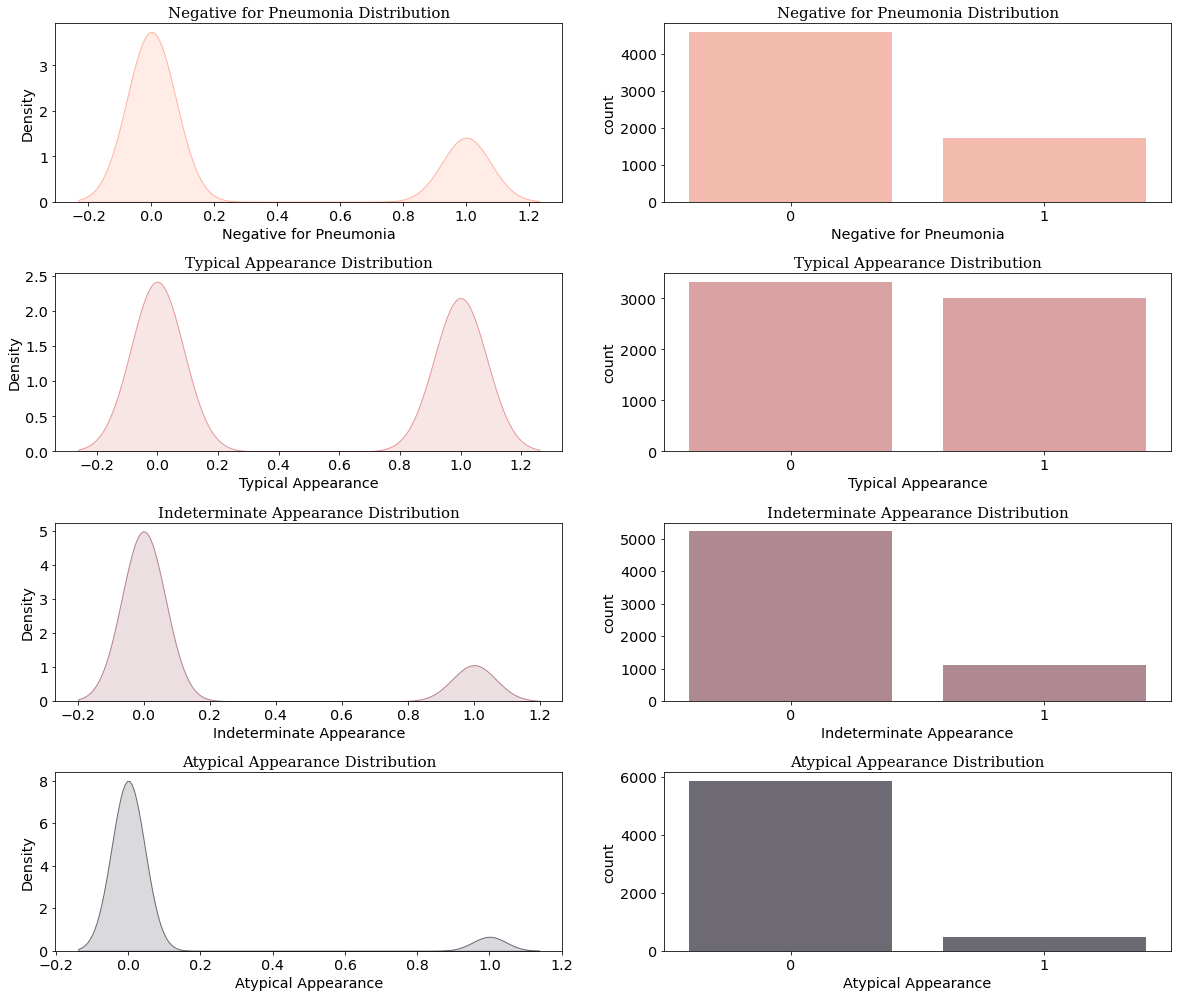

In [10]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 16),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(4,2)
sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=15)
sns.countplot(x = train_df["Negative for Pneumonia"], ax=ax[0,1],color="#ffb4a2")
ax[0,1].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=15)

sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[1,0],color="#e5989b")
ax[1,0].set_title("Typical Appearance Distribution",font="Serif", fontsize=15)
sns.countplot(x = train_df["Typical Appearance"], ax=ax[1,1],color="#e5989b")
ax[1,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=15)

sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[2,0],color="#b5838d")
ax[2,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=15)
sns.countplot(x = train_df["Indeterminate Appearance"], ax=ax[2,1],color="#b5838d")
ax[2,1].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=15)

sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[3,0],color="#6d6875")
ax[3,0].set_title("Atypical Appearance Distribution",font="Serif", fontsize=15)
sns.countplot(x = train_df["Atypical Appearance"], ax=ax[3,1],color="#6d6875")
ax[3,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=15)

fig.subplots_adjust(wspace=0.2, hspace=0.4, top=0.93)
plt.show()

In [11]:
#====== Function to plot wandb bar chart ======
def plot_wb_bar(df,col1,col2): 
    run = wandb.init(project='siim', job_type='image-visualization',name=col1,config = CONFIG)
    
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])]
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({col1 : wandb.plot.bar(table, col1,col2,title=col1)})

    run.finish()
    
#====== Function to create a dataframe of value counts ======
def count_values(col):
    df = pd.DataFrame(train_df[col].value_counts().reset_index().values,columns=[col, "counts"])
    return df

plot_wb_bar(count_values("Negative for Pneumonia"),"Negative for Pneumonia", 'counts')
plot_wb_bar(count_values("Typical Appearance"),"Typical Appearance", 'counts')
plot_wb_bar(count_values("Indeterminate Appearance"),"Indeterminate Appearance", 'counts')
plot_wb_bar(count_values("Atypical Appearance"),"Atypical Appearance", 'counts')

# DICOM data

### Image and Metadata

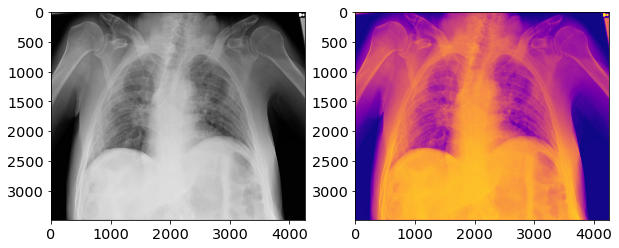

{'Accession Number': 'f6cd7f2019f5',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4256,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': 'dcc3fdf6426a',
 "Patient's Name": "'d4268f26ed05'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 3488,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'000a312787f2'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'81456c9c5423'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '526316e376d4',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'5776db0cec75'",
 'Study Time': '8ccfb6acf07f'}


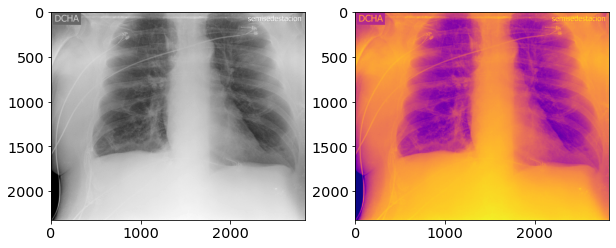

{'Accession Number': '1c2708371bc6',
 'Bits Allocated': 8,
 'Bits Stored': 8,
 'Body Part Examined': 'CHEST',
 'Columns': 2832,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 7,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.15, 0.15]',
 'Instance Number': 1,
 'Modality': 'CR',
 'Patient ID': 'f09ff9b7dab3',
 "Patient's Name": "'ef8c31f8dfdd'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2320,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'000c3a3f293f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'d8a644cc4f93'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'd09eda152722',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'ff0879eb20ed'",
 'Study Time': '543adb46f494'}


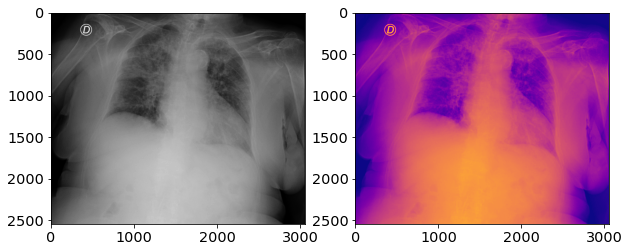

{'Accession Number': '99428f65d948',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'PORT CHEST',
 'Columns': 3056,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.139, 0.139]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '6a02c0731039',
 "Patient's Name": "'2f2fb944fe44'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2544,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'0012ff7358bc'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'22897cd1daa0'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '96fc21dd2b1f',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'9d514ce429a7'",
 'Study Time': '746186a2bbf2'}


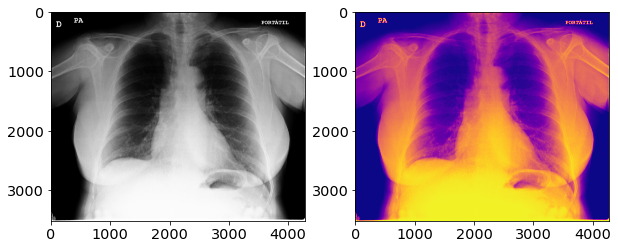

{'Accession Number': '7b889627faf1',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4280,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', "
               "'100000']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1002,
 'Modality': 'CR',
 'Patient ID': 'db63d9b7f61c',
 "Patient's Name": "'9ccd87b4511b'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME1',
 'Private Creator': 'GEIIS',
 'Rows': 3520,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'001398f4ff4f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'4d47bc042ee6'",
 'Series Number': 1002,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '3f094e1700ec',
 'Study ID': '55625fb42f3f',
 'Study Instance

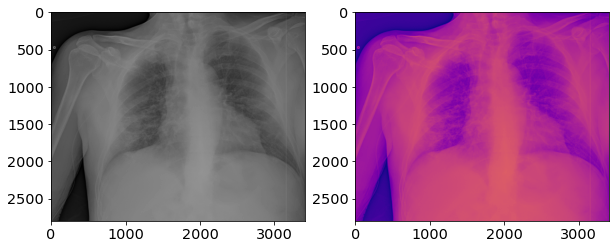

{'Accession Number': 'e9d93edf50c6',
 'Bits Allocated': 16,
 'Bits Stored': 15,
 'Body Part Examined': 'CHEST',
 'Columns': 3408,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 14,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.125, 0.125]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '605693f36f43',
 "Patient's Name": "'35bf9ddbf9e9'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME1',
 'Rows': 2800,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'001bd15d1891'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'49170afa4f27'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'a69d89c8a474',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'dfd9fdd85a3e'",
 'Study Time': '5399ff949226'}


In [12]:
voi_lut=True
fix_monochrome=True

def dicom_dataset_to_dict(filename):
    """Credit: https://github.com/pydicom/pydicom/issues/319
               https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    """
    
    dicom_header = dicom.dcmread(filename) 
    
    #====== DICOM FILE DATA ======
    dicom_dict = {}
    repr(dicom_header)
    for dicom_value in dicom_header.values():
        if dicom_value.tag == (0x7fe0, 0x0010):
            #discard pixel data
            continue
        if type(dicom_value.value) == dicom.dataset.Dataset:
            dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
        else:
            v = _convert_value(dicom_value.value)
            dicom_dict[dicom_value.name] = v
      
    del dicom_dict['Pixel Representation']
    
    #====== DICOM IMAGE DATA ======
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
    else:
        data = dicom_header.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom_header.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    modified_image_data = (data * 255).astype(np.uint8)
    
    return dicom_dict, modified_image_data

def _sanitise_unicode(s):
    return s.replace(u"\u0000", "").strip()

def _convert_value(v):
    t = type(v)
    if t in (list, int, float):
        cv = v
    elif t == str:
        cv = _sanitise_unicode(v)
    elif t == bytes:
        s = v.decode('ascii', 'replace')
        cv = _sanitise_unicode(s)
    elif t == dicom.valuerep.DSfloat:
        cv = float(v)
    elif t == dicom.valuerep.IS:
        cv = int(v)
    else:
        cv = repr(v)
    return cv

for filename in train_df.path[0:5]:
    df, img_array = dicom_dataset_to_dict(filename)
    
    fig, ax = plt.subplots(1, 2, figsize=[10, 8])
    ax[0].imshow(img_array, cmap=plt.cm.gray)
    ax[1].imshow(img_array, cmap=plt.cm.plasma)    
    plt.show()
    
    pprint.pprint(df)

In [13]:
# dicom_data_list = []
# for filename in train_df.path:
#     try:
#         data_di, img_array = dicom_dataset_to_dict(filename)
#         dicom_data_list.append(data_di)
    
#     except:
#         continue

# dicom_data_df = pd.DataFrame(dicom_data_list) 
# dicom_data_df

# #====== Saving to csv files and creating artifacts ======
# dicom_data_df.to_csv("dicom_metadata.csv")

# run = wandb.init(project='siim', name='dicom_metadata')

# artifact = wandb.Artifact('dicom_metadata', type='dataset')

# #====== Add a file to the artifact's contents ======
# artifact.add_file("dicom_metadata.csv")

# #====== Save the artifact version to W&B and mark it as the output of this run ====== 
# run.log_artifact(artifact)

# run.finish()

In [14]:
run = wandb.init(project='siim', config = CONFIG)
artifact = run.use_artifact('ruchi798/siim/dicom_metadata:v0', type='dataset')
artifact_dir = artifact.download()
run.finish()

path = os.path.join(artifact_dir,"dicom_metadata.csv")
metadata = pd.read_csv(path)
metadata = metadata.drop(columns=["Unnamed: 0"])
metadata.head()

Specific Character Set                                         Image Type  \
0             ISO_IR 100                            ['ORIGINAL', 'PRIMARY']   
1             ISO_IR 100                            ['ORIGINAL', 'PRIMARY']   
2             ISO_IR 100                             ['DERIVED', 'PRIMARY']   
3             ISO_IR 100  ['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT',...   
4             ISO_IR 100                            ['ORIGINAL', 'PRIMARY']   

    SOP Class UID SOP Instance UID    Study Date    Study Time  \
0  '71228e4340de'   '000a312787f2'  526316e376d4  8ccfb6acf07f   
1  '03a65300fa41'   '000c3a3f293f'  d09eda152722  543adb46f494   
2  '71228e4340de'   '0012ff7358bc'  96fc21dd2b1f  746186a2bbf2   
3  '03a65300fa41'   '001398f4ff4f'  3f094e1700ec  9c4f53a2d5e4   
4  '71228e4340de'   '001bd15d1891'  a69d89c8a474  5399ff949226   

  Accession Number Modality  Patient's Name    Patient ID  ... Series Number  \
0     f6cd7f2019f5       DX  'd4268f26ed05'  dcc3fdf6426a  ...             1   
1     1c2708371bc6       CR  'ef8c31f8dfdd'  f09ff9b7dab3  ...             1   
2     99428f65d948       DX  '2f2fb944fe44'  6a02c0731039  ...             1   
3     7b889627faf1       CR  '9ccd87b4511b'  db63d9b7f61c  ...          1002   
4     e9d93edf50c6       DX  '35bf9ddbf9e9'  605693f36f43  ...             1   

  Instance Number Samples per Pixel Photometric Interpretation  Rows Columns  \
0               1                 1                MONOCHROME2  3488    4256   
1               1                 1                MONOCHROME2  2320    2832   
2               1                 1                MONOCHROME2  2544    3056   
3            1002                 1                MONOCHROME1  3520    4280   
4               1                 1                MONOCHROME1  2800    3408   

  Bits Allocated Bits Stored High Bit Private Creator  
0             16          12       11             NaN  
1              8           8        7             NaN  
2             16          12       11             NaN  
3             16          12       11           GEIIS  
4             16          15       14             NaN  

[5 rows x 28 columns]

A snapshot of the newly created artifact:
<img src="https://i.imgur.com/QVHNpcB.png">

### Images and Classes

Negative for Pneumonia


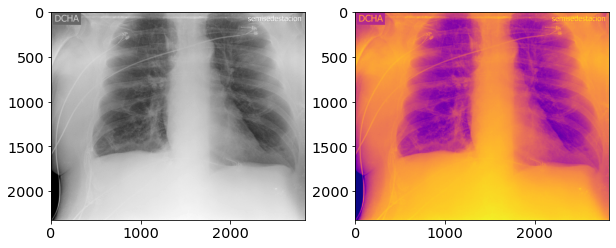

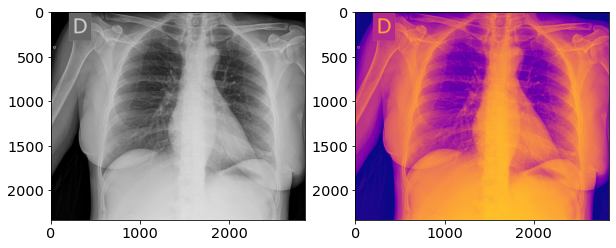

Typical Appearance


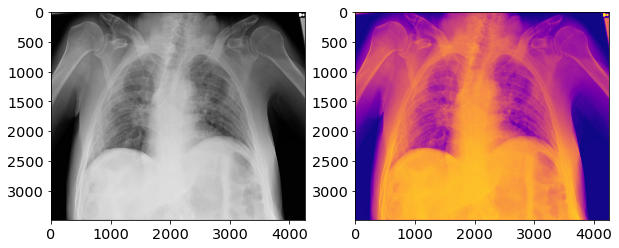

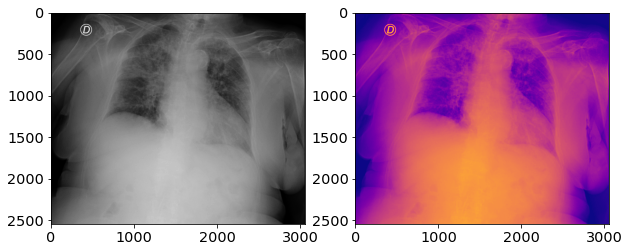

Indeterminate Appearance


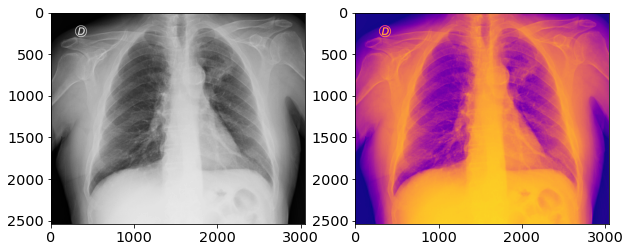

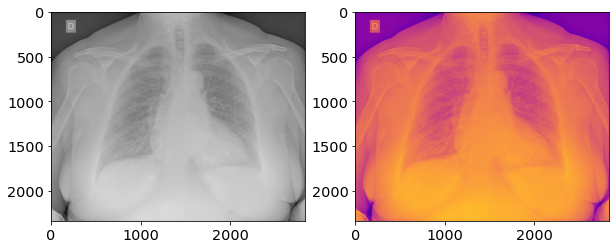

Atypical Appearance


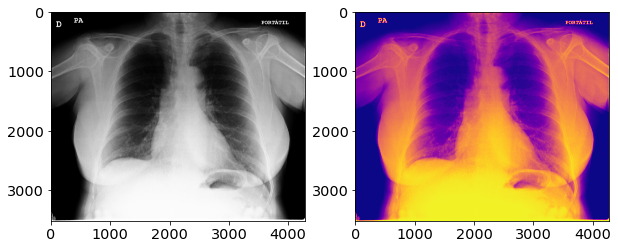

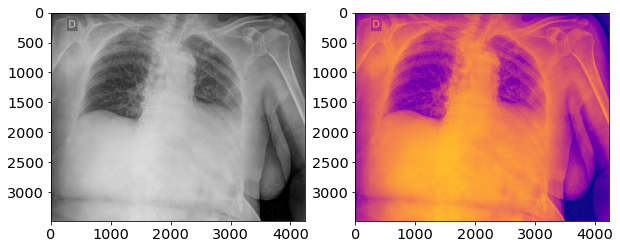

In [15]:
# initializing the run
run = wandb.init(project="siim",
                 job_type="upload",
                 config = CONFIG
                 )

# creating an artifact 
artifact = wandb.Artifact(name="dicom_images", type="raw_data")

# setting up a WandB Table object to hold the dataset
columns=["dicom image", "class"]

table = wandb.Table(
    columns=columns
)

classes = ['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
for siim_class in classes:
    print(siim_class)
    for _, row in train_df[train_df[siim_class]==1].iloc[:2].iterrows():
        filename = row['path']
        df, img_array = dicom_dataset_to_dict(filename)
        
        fig, ax = plt.subplots(1, 2, figsize=[10, 8])
        ax[0].imshow(img_array, cmap=plt.cm.gray)
        ax[1].imshow(img_array, cmap=plt.cm.plasma)   
        plt.show()
        
        img_object = Image.fromarray(img_array)
        
        # raw image
        raw_img = wandb.Image(img_object)

        # adding a row to the table
        row = [raw_img,siim_class]
        table.add_data(*row)
        
# adding the table to the artifact
artifact.add(table, "raw_examples")
    
# logging the artifact
run.log_artifact(artifact)

run.finish()

We can interact with the W&B table by specifying filters on any column to **limit the visible rows down to only rows that match**!

Here I've filtered the table to see only those images that have the class label as ```Atypical Appearance``` or ```Indeterminate Appearance```.

<img src = "https://i.imgur.com/Cbcn9nP.gif">

Super thankful to @[xhlulu](https://www.kaggle.com/xhlulu) for converting [dicom image data to jpg files](https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px)! ⚡

In [16]:
train_jpg_directory = '../input/siim-covid19-resized-to-256px-jpg/train'
test_jpg_directory = '../input/siim-covid19-resized-to-256px-jpg/test'

def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

train_images_path = getImagePaths(train_jpg_directory)
test_images_path = getImagePaths(test_jpg_directory)

print(f"{y_}Number of train images: {g_} {len(train_images_path)}\n")
print(f"{y_}Number of test images: {g_} {len(test_images_path)}\n")

def getShape(data, images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return data +" - Different image shape"
        else:
            return data +" - Same image shape " + str(shape)

Number of train images:  6334

Number of test images:  1263



In [17]:
run = wandb.init(project='siim', name='count',config = CONFIG)

wandb.log({'Training samples': len(train_images_path) , 
           'Test samples': len(test_images_path) 
          })

run.finish()

### Checking if images in each directory have the same shape

In [18]:
getShape('train',train_images_path)

'train - Same image shape (256, 256, 3)'

In [19]:
getShape('test',test_images_path)

'test - Same image shape (256, 256, 3)'

# Data Augmentation

In [20]:
def plot_augmentations(images, titles, sup_title):
    fig, axes = plt.subplots(figsize=(20, 16), nrows=3, ncols=4, squeeze=False)
    
    for indx, (img, title) in enumerate(zip(images, titles)):
        axes[indx // 4][indx % 4].imshow(img)
        axes[indx // 4][indx % 4].set_title(title, fontsize=15)
        
    plt.tight_layout()
    fig.suptitle(sup_title, fontsize = 20)
    fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)
    plt.show()
    
def augment(paths, data):
    
    # list of albumentations
    albumentations = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                              A.RandomCrop(p=1,height = 128, width = 128), A.Rotate(p=1, limit=90),
                              A.RGBShift(p=1), A.RandomSnow(p=1),
                              A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1),
                              A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]
    
    # image titles
    titles = ["RandomSunFlare","RandomFog","RandomBrightness",
                       "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]
    
    for i in paths:
        image_path = i
        
        # getting image name from path
        image_name = image_path.split("/")[4].split(".")[0]
        
        # reading image
        image = cv2.imread(image_path)

        # list of images
        images = []
        
        # creating image augmentations
        for augmentation_type in albumentations:
            augmented_img = augmentation_type(image = image)['image']
            images.append(augmented_img)

        # original image
        titles.insert(0, "Original")
        images.insert(0,image)  
        
        sup_title = "Image Augmentation for " + data + " - " + image_name
        plot_augmentations(images, titles, sup_title)
        
        titles.remove("Original")

### Data Augmentation (train samples)

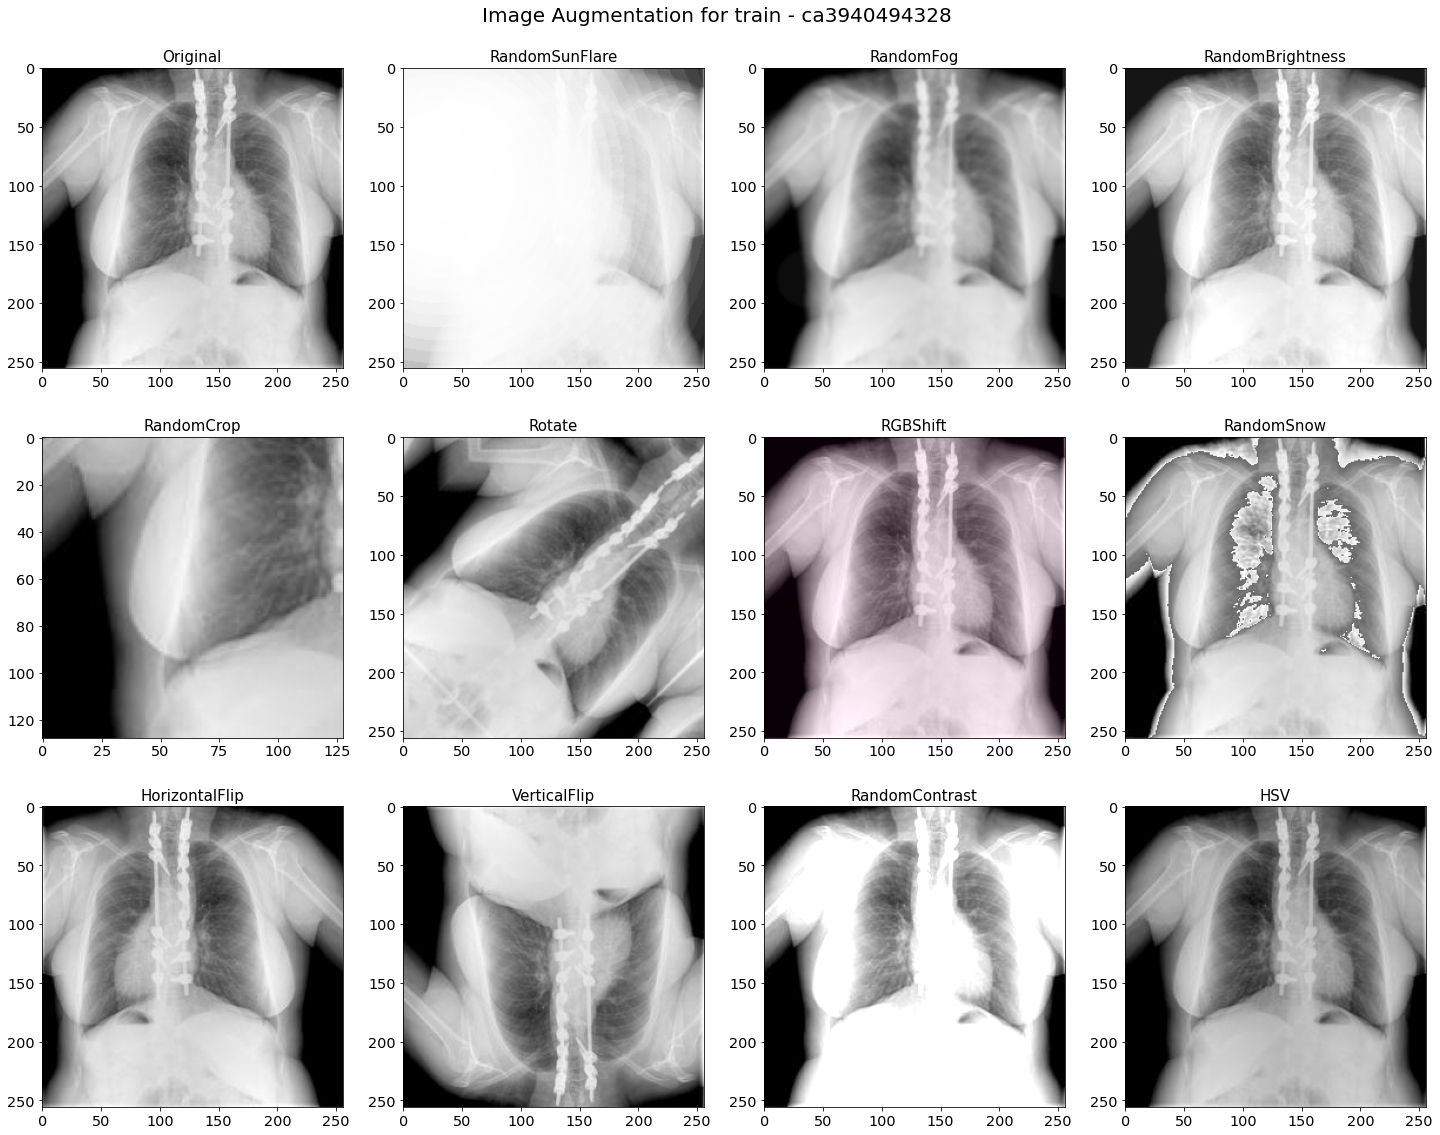

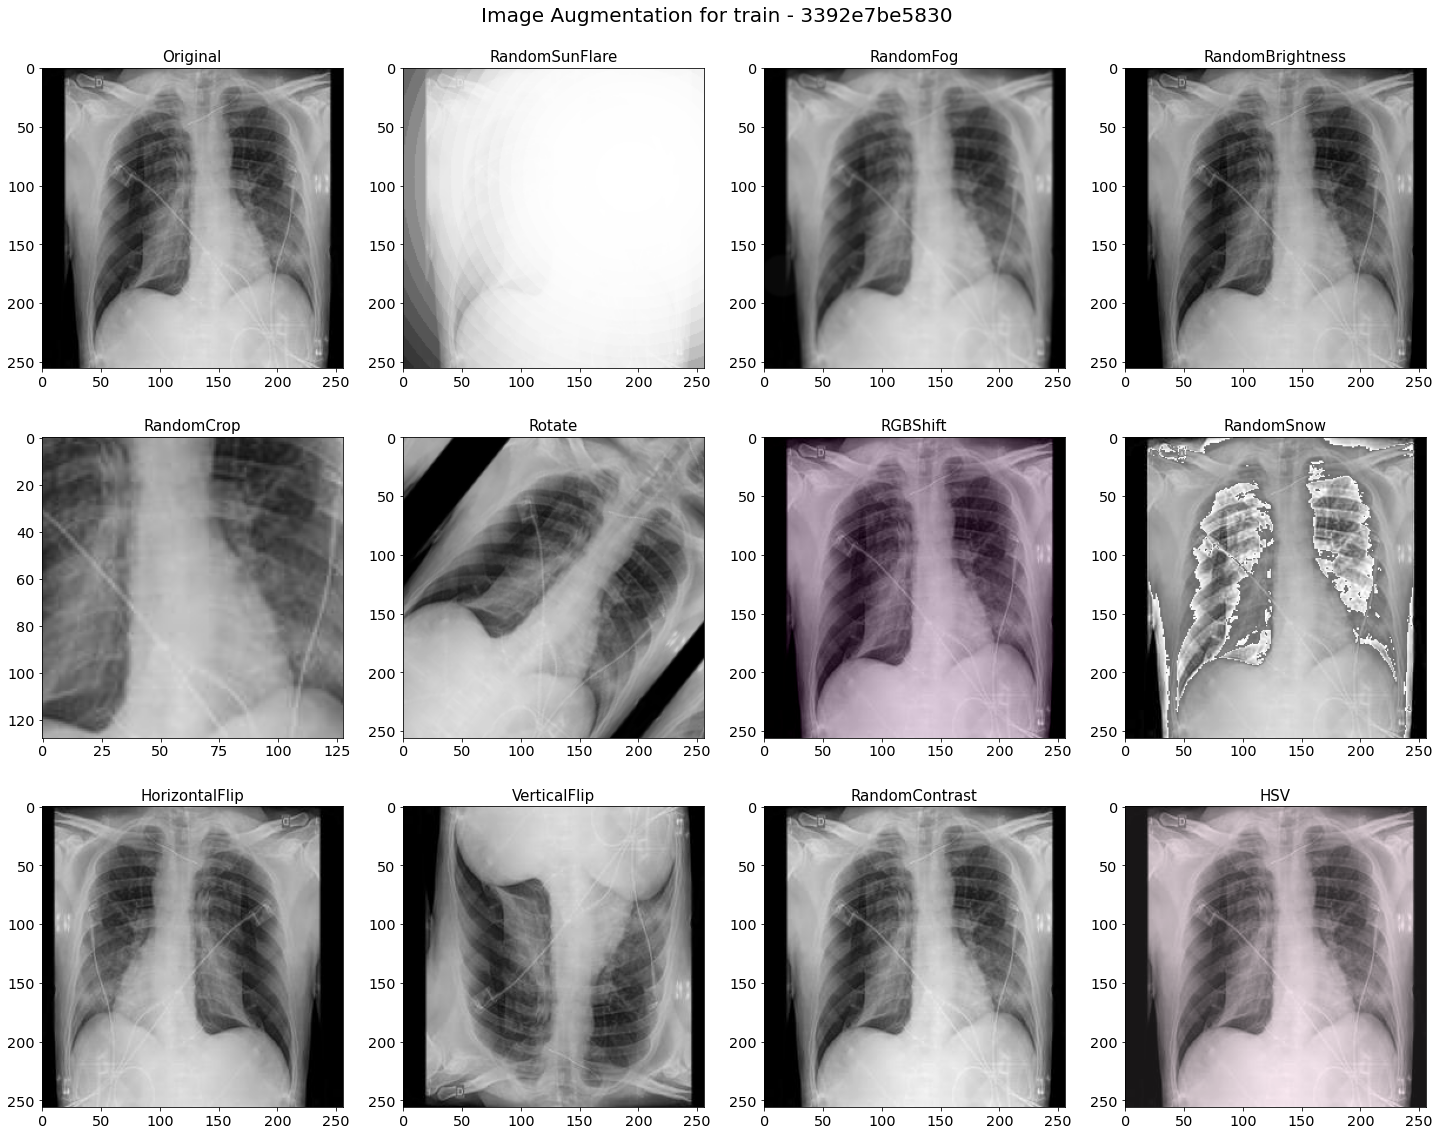

In [21]:
augment(train_images_path[0:2],'train')

### Data Augmentation (test samples)

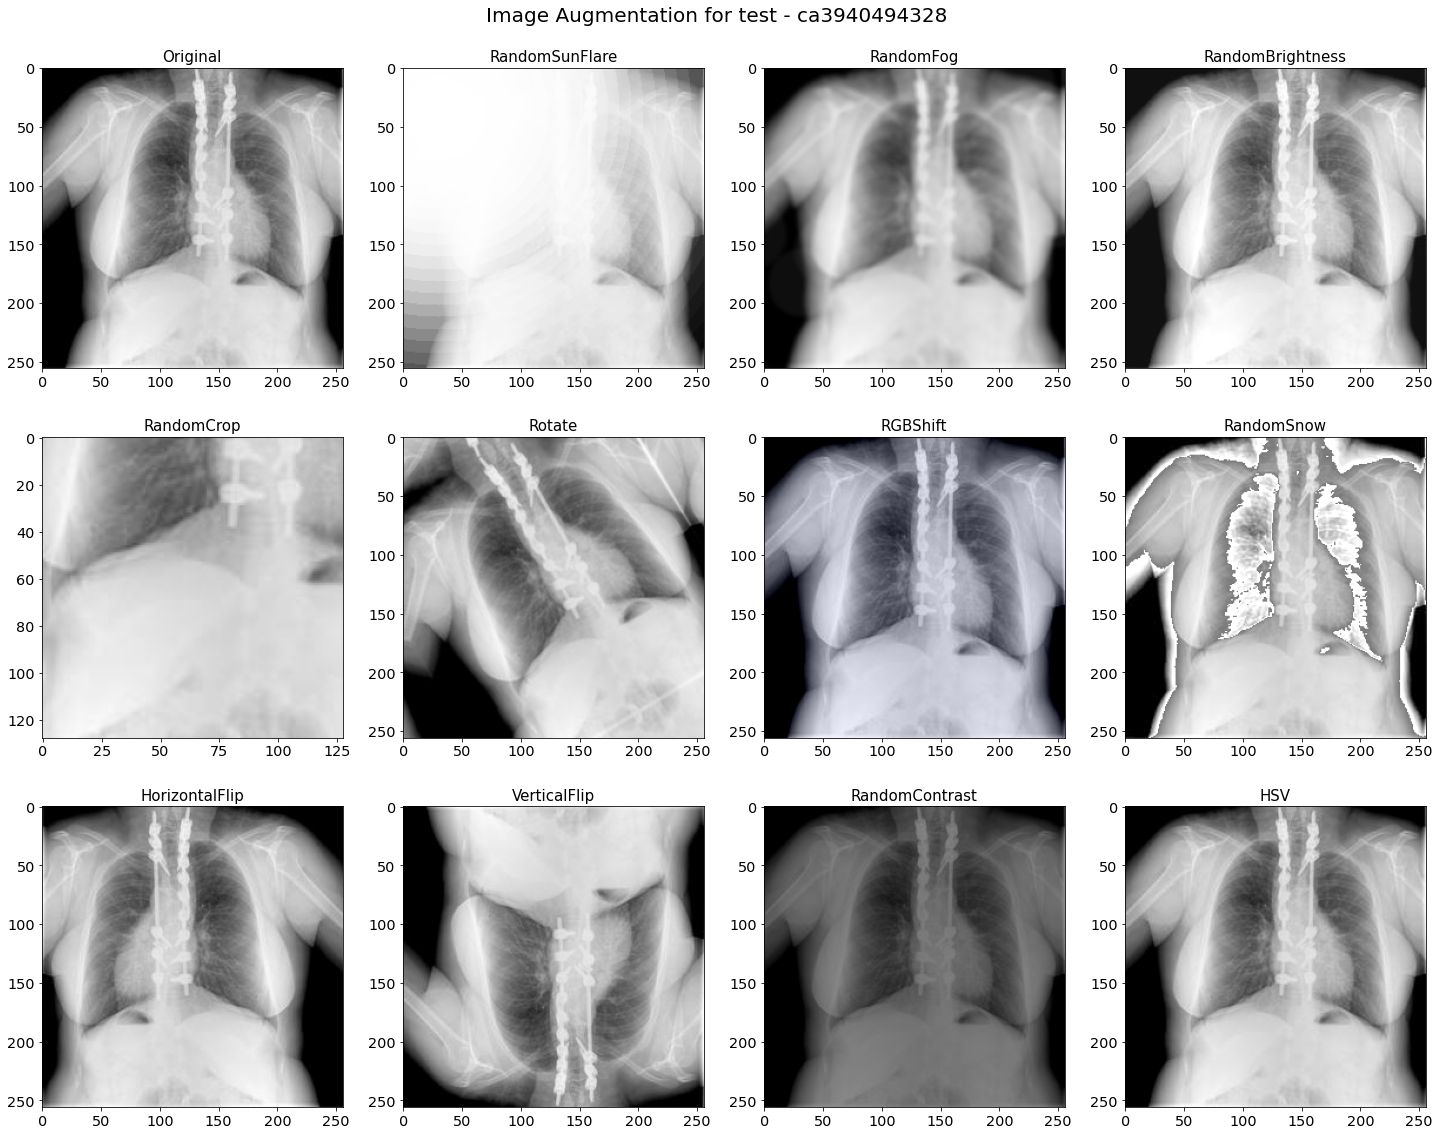

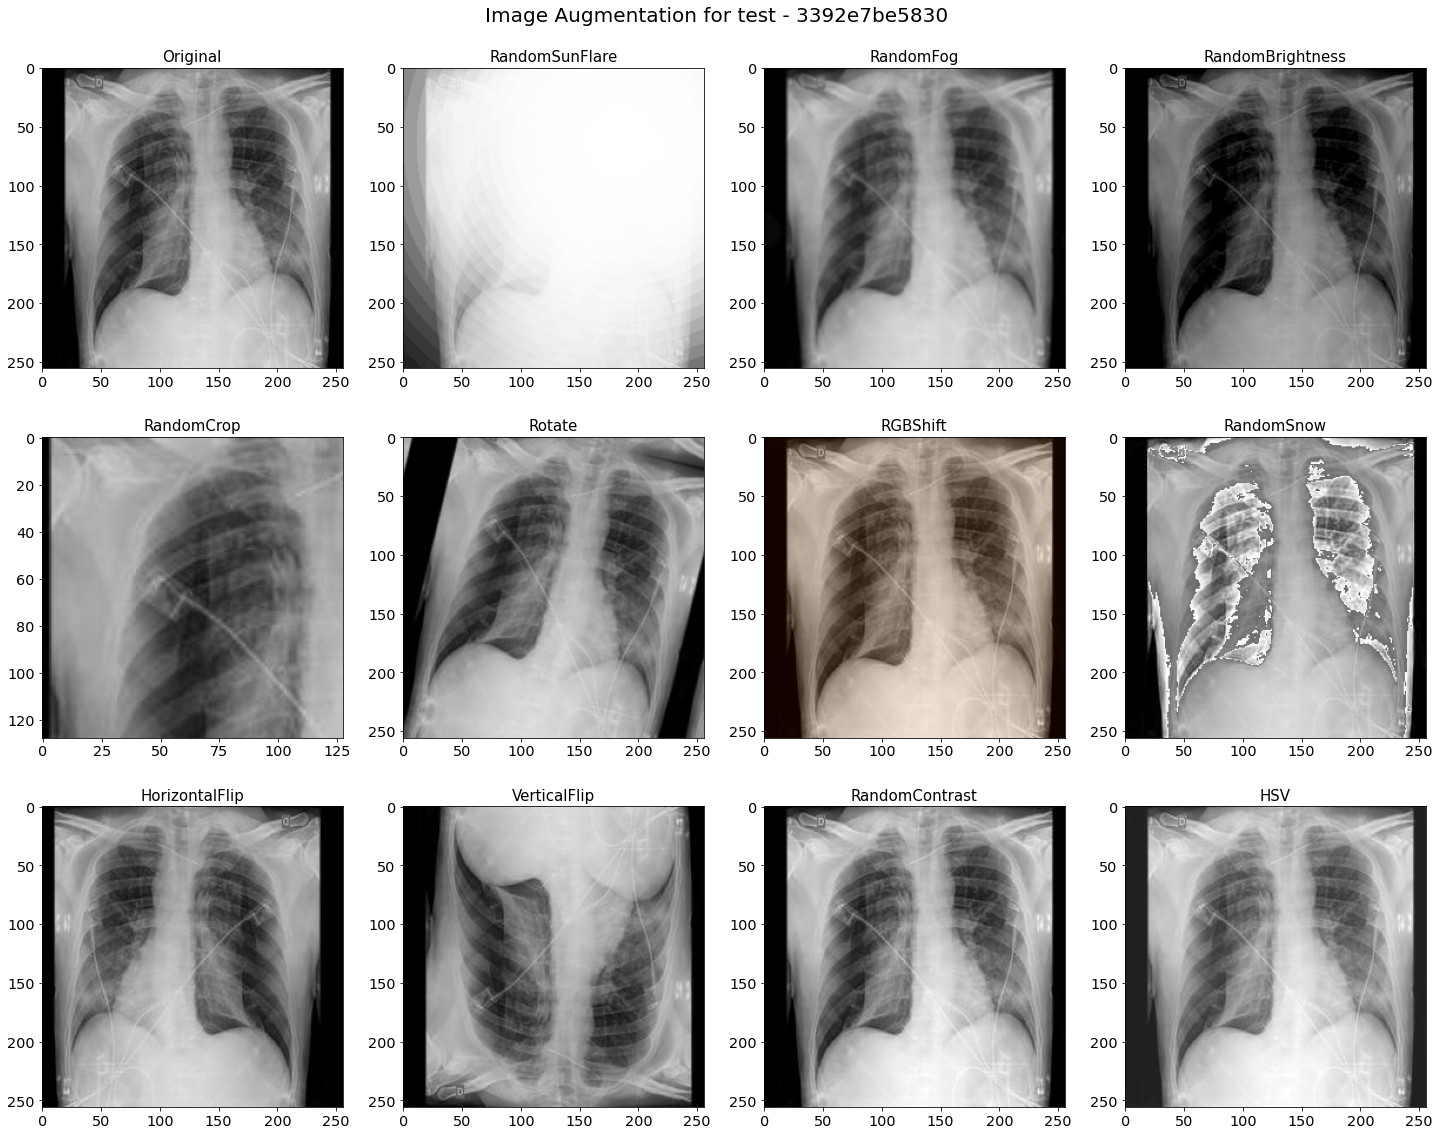

In [22]:
augment(train_images_path[0:2],'test')

I've created a [dataset](https://www.kaggle.com/ruchi798/siimfisabiorsna-covid19-detection-augmented) of image augmentations for all the training and testing images as well 🥳

This is what my [project](https://wandb.ai/ruchi798/siim?workspace=user-ruchi798) looks like on the W&B dashboard ⬇️
<img src="https://i.imgur.com/lFIrsJT.png">

Work in Progress ⏳